# E: Build & Tune Models

## INPUTS

In [1]:
retune = False  # hyperparameter tuning
forprod = True # typically run this last after setting best params

## imports

In [2]:
#for formatting
import jupyter_black

jupyter_black.load(
    lab=False,
)

<IPython.core.display.Javascript object>

In [3]:
import dill
import importlib  # for importing other packages
import copy
import os
import pandas as pd
import numpy as np
from patsy import dmatrices

import mlflow  # model tracking

from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# H2O , needs java installed & on path / environment variable (java --version to test)
import h2o
from h2o.estimators import *
from h2o.grid import *
from mlflow.models.signature import infer_signature

# evaluation
from sklearn import tree
import shap  # package used to calculate Shap values
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Prep work

In [4]:
# start logging

# set location for mlruns
# mlflow.set_tracking_uri("file:D:/Stuff/OneDrive/MLflow")

# set experiment
if forprod:
    experiment_name = "P1-AnalyzeTrades_f_core"
else:
    experiment_name = "Development"
try:
    mlflow.set_experiment(experiment_name)
except:
    mlflow.create_experiment(experiment_name)

mlflow.sklearn.autolog()

In [5]:
## read in data

df_XY = pd.read_csv("output/e_resultcleaned.csv")

In [6]:
## clean column names deprecated

# cols = list(df_XY.columns)
# new_cols = []

# for c in cols:
#     new_cols.append(
#         "".join(
#             e.replace(".", "pt")
#             for e in c
#             if (e.isalnum()) | (e == "_") | (e == "%") | (e == ".")
#         )
#     )

# print(f"cols {new_cols}")

# df_XY.columns = new_cols~~

# df_XY.head()

## variable selection

In [7]:
print(df_XY.columns)

Index(['Unnamed: 0', '%_TO_STOP', '%_TO_TARGET',
       'AAII_0_LEVEL_0_REPORTED_DATE', 'AAII_1_LEVEL_0_REPORTED_BULLISH',
       'AAII_2_LEVEL_0_REPORTED_NEUTRAL', 'AAII_3_LEVEL_0_REPORTED_BEARISH',
       'AAII_4_LEVEL_0_REPORTED_TOTAL', 'AAII_BULLISH_8-WEEK_MOV_AVG',
       'AAII_BULLISH_AVERAGE_+ST._DEV.', 'AAII_BULLISH_AVERAGE_-_ST._DEV.',
       'AAII_BULLISH_BULL-BEAR_SPREAD', 'AAII_BULLISH_BULLISH_AVERAGE',
       'AAII_DATE', 'AAII_S&P_500_WEEKLY_CLOSE', 'AAII_S&P_500_WEEKLY_HIGH',
       'AAII_S&P_500_WEEKLY_LOW', 'ACTION', 'AGE', 'AT_PRICE',
       'CASH_CHG_(PNL)', 'CATEGORY', 'CLOSEACT', 'CLOSE_DATE', 'CLOSE_PRICE',
       'CLOSE_^GSPC', 'CLOSE_^GSPC_200MA', 'CLOSE_^VIX', 'COMMENTS',
       'COMMENTS.1', 'COMMISSION', 'COMM_TOT',
       'COMPANY_NAME_(IN_ALPHABETICAL_ORDER)', 'CURRENT_PRICE', 'DATE',
       'DATE_YAHOOFINANCE', 'DAYOFWEEK0MON', 'DAYSTOFYEND', 'EPS1', 'EPS2',
       'FILENAME', 'FYEND', 'FYEPSNXT', 'GROWTH_0.5TO0.75', 'LASTUPDATED',
       'OPENACT', 'OPEN_

In [8]:
target = "PCT_RET_FINAL"

numeric_features = [
    "TGT_FWD_P_E",
    "YEARS_TO_NORMALIZATION",
    "CLOSE_^VIX",
    "AAII_BULLISH_BULL-BEAR_SPREAD",
    "%_TO_STOP",
    "%_TO_TARGET",
   # "GROWTH_0.5TO0.75", VIF is too high
    "ROIC_(BW_ROA_ROE)",
    "DAYOFWEEK0MON",
    "SP500FROM200MA",
]

categorical_features = [
    "OPENACT",
    "CATEGORY",
]  #   categorical not stable as others captured and this is not stable

variables = numeric_features + categorical_features

# dtypes = pd.Series(df_XY.dtypes)
# selected_vars = dtypes[variables]
# varlist = []

# cols_num = df_XY.select_dtypes(include="number").columns
# idx = 0

# # create variable string
# for v in variables:
#     if idx != 0:
#         varlist.append(" + ")

#     # if v not in cols_num:
#     #     varlist.append('C(')

#     # varlist.append("Q('")
#     varlist.append(v)
#     # varlist.append("')")

#     # if v not in cols_num:
#     #     varlist.append(')')

#     idx = idx + 1

# varstring = "".join(varlist)

In [9]:
## Variables for columns

y = df_XY[[target]]
X = df_XY[variables]

# deprecated
# formula =  f""" {target} ~ 1 + {varstring}"""
# y , X = dmatrices(formula, df_XY, return_type='dataframe')

assert X.shape[0] == df_XY.shape[0], "rows mismatched, probably due to NAs"

In [10]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X[numeric_features].columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X[numeric_features].values, i)
                          for i in range(len(X[numeric_features].columns))]

print(vif_data)

                         feature       VIF
0                    TGT_FWD_P_E  1.471410
1         YEARS_TO_NORMALIZATION  6.557711
2                     CLOSE_^VIX  6.084212
3  AAII_BULLISH_BULL-BEAR_SPREAD  1.839501
4                      %_TO_STOP  1.240367
5                    %_TO_TARGET  1.989660
6              ROIC_(BW_ROA_ROE)  1.799238
7                  DAYOFWEEK0MON  2.834016
8                 SP500FROM200MA  2.206179


In [11]:
X.dtypes

TGT_FWD_P_E                      float64
YEARS_TO_NORMALIZATION             int64
CLOSE_^VIX                       float64
AAII_BULLISH_BULL-BEAR_SPREAD    float64
%_TO_STOP                        float64
%_TO_TARGET                      float64
ROIC_(BW_ROA_ROE)                float64
DAYOFWEEK0MON                      int64
SP500FROM200MA                   float64
OPENACT                           object
CATEGORY                          object
dtype: object

In [12]:
# train test data

X_train, X_test, y_train, y_test, XY_train, XY_test = train_test_split(
    X, y, df_XY, test_size=0.33, random_state=42
)

# y..to_numpy().ravel()

In [13]:
## sample tune & run model using hyperopt

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
# from hpsklearn import HyperoptEstimator
# from hpsklearn import any_regressor
# from hpsklearn import any_preprocessing
# from hyperopt import tpe
# # load dataset
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
# dataframe = read_csv(url, header=None)
# # split into input and output elements
# data = dataframe.values
# data = data.astype('float32')
# X, y = data[:, :-1], data[:, -1]
# # split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# # define search
# model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)
# # perform the search
# model.fit(X_train, y_train)
# # summarize performance
# mae = model.score(X_test, y_test)
# print("MAE: %.3f" % mae)
# # summarize the best model
# print(model.best_model())

## support functions

In [14]:
# looks reasonable
# https://www.kaggle.com/jpopham91/gini-scoring-simple-and-efficient
def gini_normalized(y_true, y_pred, sample_weight=None):
    # check and get number of samples
    assert (
        np.array(y_true).shape == np.array(y_pred).shape
    ), "y_true and y_pred need to have same shape"
    n_samples = np.array(y_true).shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    if sample_weight == None:
        sample_weight = np.ones(n_samples)

    arr = np.array([y_true, y_pred, sample_weight]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]  # true col sorted by true
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]  # true col sorted by pred

    true_order_wgts = arr[arr[:, 0].argsort()][::-1, 2]
    pred_order_wgts = arr[arr[:, 0].argsort()][::-1, 2]

    # get Lorenz curves
    L_true = np.cumsum(np.multiply(true_order, true_order_wgts)) / np.sum(
        np.dot(true_order, true_order_wgts)
    )
    L_pred = np.cumsum(np.multiply(pred_order, pred_order_wgts)) / np.sum(
        np.multiply(pred_order, pred_order_wgts)
    )
    L_ones = np.multiply(np.linspace(1 / n_samples, 1, n_samples), pred_order_wgts)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred / G_true


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    formula,
    weights=None,
    tweedie_powers=None,
):
    """
    Evaluate an estimator on train and test sets with different metrics
    Requires active run on mlflow and estimator with .predict method
    """
    from sklearn.metrics import mean_absolute_error, mean_squared_error, auc, r2_score
    from functools import partial
    from sklearn.metrics import mean_tweedie_deviance
    from quantumtools import metrics as qmetrics  # for plotting

    mlflow.set_tag("run_id", mlflow.active_run().info.run_id)
    mlflow.log_params({"formula": formula})

    metrics = [
        # ("default score", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
        ("gini", gini_normalized),
        ("ginierror", qmetrics.ginierror),
        ("r2_score", r2_score),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = {}
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        if weights != None:
            y, _weights = df[target], df[weights]
        else:
            y, _weights = df[target], None

        if isinstance(estimator, tuple) and len(estimator) == 2:
            # Score the model consisting of the product of frequency and
            # severity models.
            est_freq, est_sev = estimator
            y_pred = est_freq.predict(X) * est_sev.predict(X)
        elif "h2o" in str(type(estimator)):
            y_pred = (
                estimator.predict(h2o.H2OFrame(X)).as_data_frame().to_numpy().ravel()
            )  # ensure 1D array
        else:
            y_pred = estimator.predict(X)

        for score_label, metric in metrics:
            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res[score_label + "_" + subset_label] = score

    return res


def to_categorical(x):
    return x.astype("category")


def to_float(x):
    return x.astype(float)


# def log_w_validate(y_true, y_pred, formula:str = ''):
#     """validates reg model and log metrics to active mlflow run.
#     Requires active mlflow run to wrun

#     Args: \n
#         y_true (array): [actual results] \n
#         y_pred (array): [predicted results] \n
#     """

#     from sklearn import metrics

#     mlflow.set_tag('run_id', mlflow.active_run().info.run_id)
#     mlflow.log_params({"formula":formula})

#     test_score_r2 = metrics.r2_score(y_true, y_pred)

#     mlflow.log_metric("test_r2", test_score_r2)
#     print(f'r2 score {test_score_r2}')

#     return

## Model 5 hist boosting w optional tuning

2024/12/28 21:31:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\mlflow\data\pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Binning 0.000 GB of training data: 0.004 s
Binning 0.000 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.15940, val loss: 0.03884, in 0.003s
[2/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.15624, val loss: 0.03867, in 0.004s
[3/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.15331, val loss: 0.03902, in 0.002s
[4/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.15064, val loss: 0.03904, in 0.002s
[5/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.14815, val loss: 0.03960, in 0.002s
[6/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.14588, val loss: 0.03983, in 0.002s
[7/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.14375, val loss: 0.04055, in 0.002s
[8/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.14180, val loss: 0.04114, in 0.002s
[9/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.13994, val loss: 0.04158, in 0.003s
[10/100] 1 tree, 4 leaves, max depth = 2, train loss: 0.1382

2024/12/28 21:31:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\mlflow\models\signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/12/28 21:31:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Stanley\.v

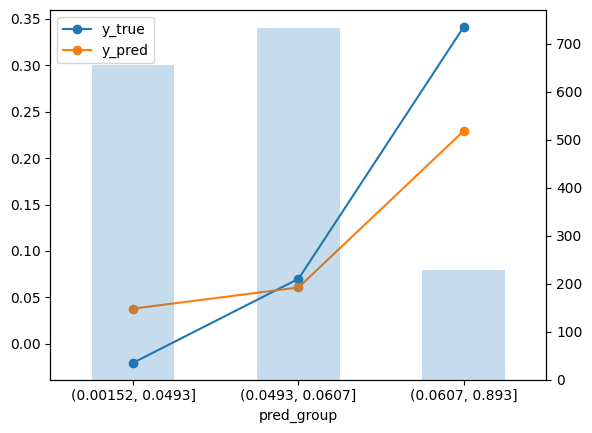

2024/12/28 21:31:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\mlflow\data\pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


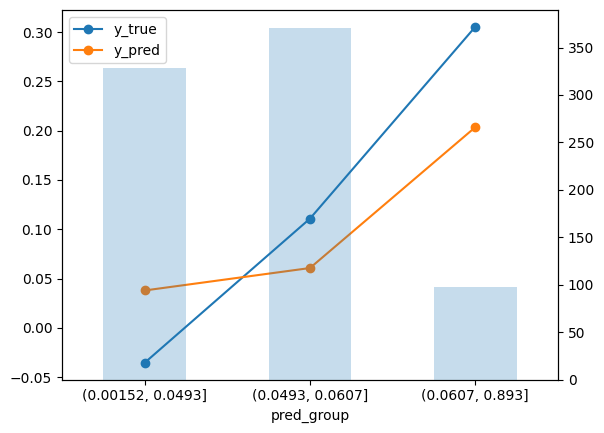

runid = 99a3dbe274ac405085e5becc687f711e


In [15]:
mlflow.end_run()
mlflow.start_run(run_name="sklearn_hgbm")

numeric_transformer = Pipeline(
    steps=[
        ("to_float", FunctionTransformer(func=to_float)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("to_categorical", FunctionTransformer(func=to_categorical)),
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
    ]
)

# based on variable order
categorical_mask = [False] * len(numeric_features) + [True] * len(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


# tuning
if retune:
    func_f = importlib.import_module("P1-AnalyzeTrades_f_buildmodel_func")

    gini_scorer = make_scorer(func_f.gini_sklearn, greater_is_better=True)

    # use hyperopt package with to better search
    # https://github.com/hyperopt/hyperopt/wiki/FMin
    # use userdefined Gini, as it measures differentiation more
    def objective_gbr(params):
        "objective_gbr function for hyper opt, params is dict of params for mdl"
        mlflow.start_run(nested=True)
        parameters = {}
        for k in params:
            parameters[k] = params[k]
        mdl = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                (
                    "estimator",
                    HistGradientBoostingRegressor(
                        random_state=0,
                        n_iter_no_change=20,
                        **parameters,
                        categorical_features=categorical_mask,
                    ),
                ),
            ]
        )
        score = cross_val_score(
            mdl, X_train, y_train.squeeze(), scoring=gini_scorer, cv=5
        ).mean()
        print("Gini {:.3f} params {}".format(score, parameters))
        mlflow.end_run()
        return score

    # need to match estimator
    space = {
        # low # high # number of choices
        "learning_rate": hp.loguniform("learning_rate", -3, 0),
        "max_depth": hp.quniform("max_depth", 1, 4,1)
    }

    best_params = fmin(fn=objective_gbr, space=space, algo=tpe.suggest, max_evals=5)

    for key in best_params.keys():
        if int(best_params[key]) == best_params[key]:
            best_params[key] = int(best_params[key])

    print("Hyperopt estimated optimum {}".format(best_params))

else:
    best_params = {'learning_rate': 0.05749546741097925, 'max_depth': 2}  # done from previous runs

mdl = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "estimator",
            HistGradientBoostingRegressor(
                random_state=0,
                **best_params,
                categorical_features=categorical_mask,
                early_stopping=True,
                validation_fraction=0.25,
                verbose=True,
            ),
        ),
    ]
)
# reg = GradientBoostingRegressor(random_state=0)
mdl.fit(X_train, y_train.squeeze(), estimator__sample_weight=XY_train["WEIGHT"])

# log with validation
# log_w_validate(y_test, y_pred, formula)
res = score_estimator(mdl, X_train, X_test, XY_train, XY_test, target, "")

mlflow.log_metrics(res)
mlflow.set_tag("target", target)

# addition artifacts
# visualize a single tree
# Get a tree
# sub_tree_1 = reg.estimators_[0, 0]  # pull first 1 estimator, actual regressor vs array

# tree.plot_tree(sub_tree_1, feature_names=list(X_train.columns), filled=True, fontsize=7)

# plt.tight_layout()
# plt.savefig("tree_plot1.png", bbox_inches="tight")
# plt.show()

# mlflow.log_artifact("tree_plot1.png")

# save requirements
os.system("pipenv requirements output/requirements.txt")
mlflow.log_artifact("output/requirements.txt")

# save categorical dict values
cat_dict = {}
for c in categorical_features:
    cat_dict[c] = list(X_train[c].unique())

with open(f"cat_dict.pkl", "wb") as handle:
    dill.dump(cat_dict, handle, recurse=True)

mlflow.log_artifact(f"cat_dict.pkl")

os.remove(f"cat_dict.pkl")

print(f"runid = {mlflow.active_run().info.run_id}")

mlflow.end_run()

In [16]:
XY_test[target]

410    -0.088376
199    -0.547658
1670    0.177403
1934   -0.252816
1036   -0.084755
          ...   
1965    0.116763
1159    0.033496
2036   -0.193854
1389    0.110838
436    -0.069439
Name: PCT_RET_FINAL, Length: 797, dtype: float64

In [17]:
res

{'mean abs. error_train': 0.208717311490961,
 'mean squared error_train': 0.1778274759623485,
 'gini_train': 0.37837944264895795,
 'ginierror_train': 0.8457575828473699,
 'r2_score_train': 0.12901207065819353,
 'mean abs. error_test': 0.21526195514709415,
 'mean squared error_test': 0.15197762233914774,
 'gini_test': 0.36089803228783823,
 'ginierror_test': 0.7969172244822085,
 'r2_score_test': 0.03456731840157523}

## SHAP test

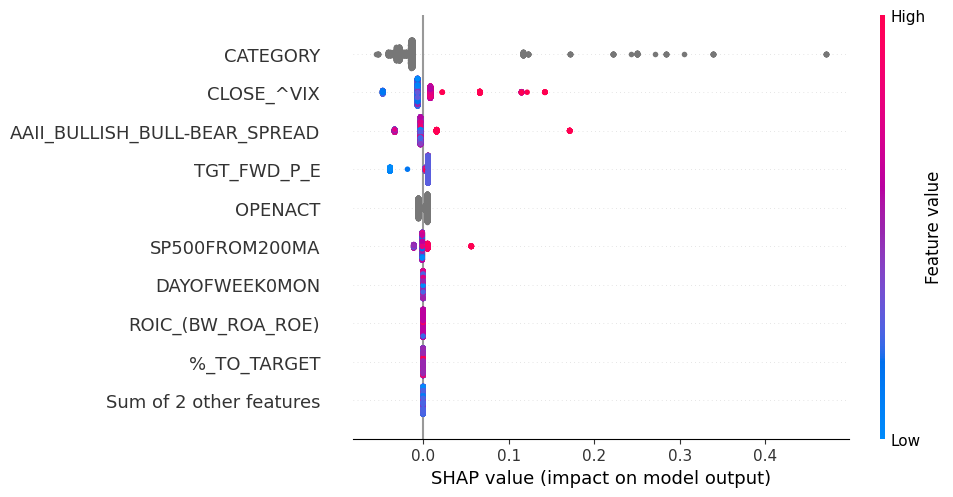

category impute failed


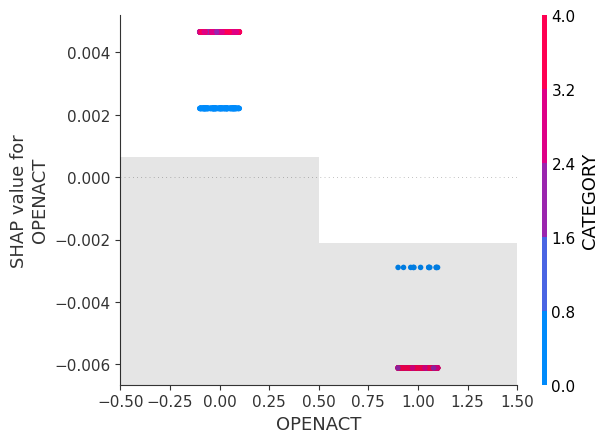

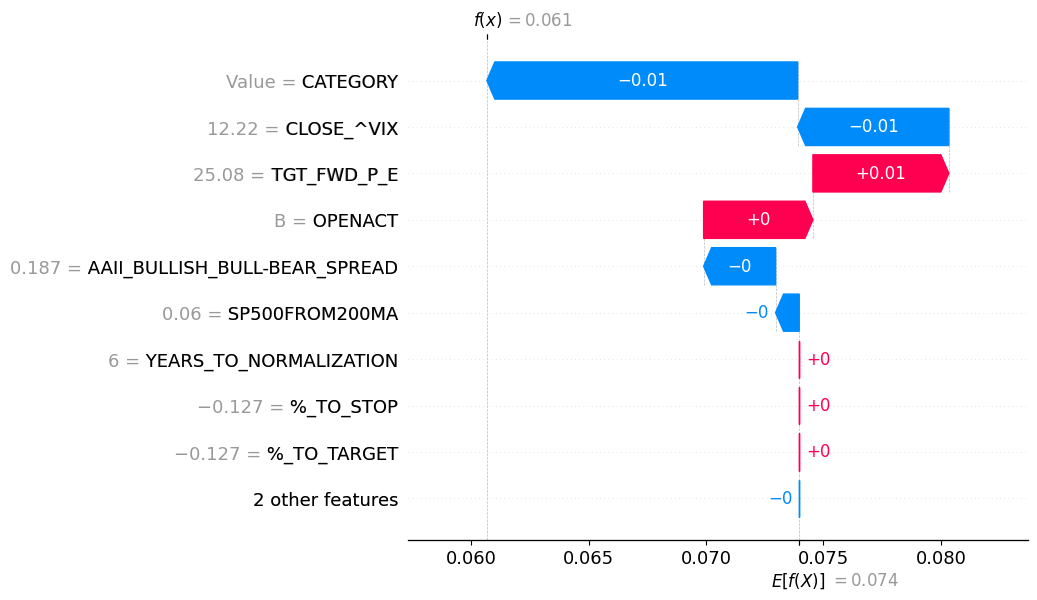

In [18]:
explainer = shap.Explainer(mdl[-1])

# fix save expected value
if len(explainer.expected_value.shape) > 0:
    ev = explainer.expected_value[0]
    explainer.expected_value = ev

shap_obj = explainer(mdl[0].transform(X_train))


var = "OPENACT"

## fix shap_obj, requires column transformer in step position 0 ,
## categorical in position 1


# def update_shap_obj(shap_obj, X_train, encoder):

shap_obj.feature_names = list(X_train.columns)
categorical_names = list(X_train.select_dtypes(include=["object"]).columns)
col_idx = list(np.where(np.isin(shap_obj.feature_names, categorical_names))[0])

shap_cat = copy.deepcopy(shap_obj)
shap_cat.data = np.array(shap_obj.data, dtype="object")
res_arr = (
    mdl[0]
    .transformers_[1][1][1]
    .inverse_transform(
        pd.DataFrame(shap_cat.data[:, col_idx], columns=[categorical_names])
    )
)
for i, loc in enumerate(col_idx):
    shap_cat.data[:, loc] = res_arr[:, i]

# new_dtype = "object"
# res_arr.astype(
#     [(col, new_dtype) if d[0] in categorical_names else d for d in res_arr.dtype.descr]
# )

# col_idx = shap_obj.feature_names.index(var)
# ord_encode_idx = mdl[0].transformers_[1][2].index(var)

shap.plots.beeswarm(shap_cat)
fig, ax = plt.subplots()

shap.plots.scatter(shap_obj[:, var], ax=ax, show=False, color=shap_obj)

if var in categorical_names:
    try:
        orig_list = ax.get_xticks()
        new_list = np.insert(
            mdl[0].transformers_[1][1][1].categories_[categorical_names.index(var)],
            0,
            "Unknown",
        )

        # this replace can fail bc xticks no not necessarily match choices
        for i in range(len(orig_list) - len(new_list)):
            new_list = np.append(new_list, orig_list[i + len(new_list)])#
    
        ax.set_xticks(orig_list)
        ax.set_xticklabels(new_list)
    except:
        print("category impute failed")

plt.show()

shap.plots.waterfall(shap_cat[0])

In [19]:
# QA
df_XY[variables + [target] + ['WEIGHT']].tail(10)

,TGT_FWD_P_E,YEARS_TO_NORMALIZATION,CLOSE_^VIX,AAII_BULLISH_BULL-BEAR_SPREAD,%_TO_STOP,%_TO_TARGET,ROIC_(BW_ROA_ROE),DAYOFWEEK0MON,SP500FROM200MA,OPENACT,CATEGORY,PCT_RET_FINAL,WEIGHT
2405,-4.00,6,14.71,0.139706,-0.3971,0.4022,-3.00,1,0.109100,B,Other,0.046442,1.0
2406,20.82,4,14.71,0.139706,0.1515,-0.7213,0.20,1,0.109100,S,SGrowth,-0.277808,1.0
2407,7.66,8,14.31,0.214953,0.2637,-0.7419,0.05,3,0.100439,S,SGrowth,-0.027562,1.0
2408,13.44,8,14.31,0.214953,0.2025,-0.7415,0.08,3,0.100439,S,SGrowth,-0.289455,1.0
2409,-4.00,6,14.31,0.214953,-0.3439,0.5259,-3.00,3,0.100439,B,Other,0.075603,1.0
2410,13.03,20,14.10,0.080645,0.1940,-0.8908,0.04,2,0.100683,S,Value,0.122547,1.0
2411,7.66,8,13.34,-0.015936,0.2175,-0.7513,0.05,0,0.107484,S,SGrowth,0.121236,1.0
2412,7.66,8,13.34,-0.015936,0.2175,-0.7513,0.05,0,0.107484,S,SGrowth,0.009145,1.0
2413,13.44,8,24.09,0.092857,0.3746,-0.7361,0.08,3,0.062311,S,SGrowth,0.094662,1.0
2414,7.66,8,24.09,0.092857,0.3405,-0.7262,0.05,3,0.062311,S,SGrowth,0.097079,1.0
